<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 (Assignment) -- The Vanishing Gradient Problem</h2>

<b>Authors:</b> Brandstetter, Schäfl<br>
<b>Date:</b> 23-03-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

# Exercise 0

- Import the same modules as discussed in the lecture notebook.
- Check if your model versions are correct.

In [1]:
import u3_utils as u3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial
from pathlib import Path
from PIL import Image, ImageOps
from scipy import signal
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from torch.utils.data import DataLoader, TensorDataset

In [2]:
u3.check_module_versions()

Installed Python version: 3.7 (✓)
Installed numpy version: 1.17.2 (✓)
Installed pandas version: 1.0.1 (✓)
Installed PyTorch version: 1.3.1 (✓)
Installed scikit-learn version: 0.22.2.post1 (✓)
Installed scipy version: 1.4.1 (✓)
Installed matplotlib version: 3.0.2 (✓)
Installed seaborn version: 0.10.0 (✓)
Installed PIL version: 7.0.0 (✓)


# Exercise 1

- Load the Fashion-MNIST dataset.
- Display the first 5 elements of the dataset.
- Create a training and a test dataset (ratio $7:3$)

In [3]:
fashion_mnist_data = u3.load_fashion_mnist()
fashion_mnist_data[:5]

,PX_0,PX_1,PX_2,PX_3,PX_4,PX_5,PX_6,PX_7,PX_8,PX_9,...,PX_775,PX_776,PX_777,PX_778,PX_779,PX_780,PX_781,PX_782,PX_783,item_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
np.random.seed(42)
fashion_mnist_train, fashion_mnist_test = u3.split_data(data=fashion_mnist_data, test_size=0.3)

print(f'Size full data set: {fashion_mnist_data.shape[0]}')
print(f'Size train set: {fashion_mnist_train.shape[0]}')
print(f'Size test set: {fashion_mnist_test.shape[0]}')

Size full data set: 70000
Size train set: 49000
Size test set: 21000


# Interlude (nothing to do here)

We set here the input dimension, the output dimension and the device used for calculation (GPU if available).

In [5]:
input_dim = 784
output_dim = 10
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')

We create a dataloader for the training and for the test data set:

In [6]:
image_width = int(np.sqrt(len(fashion_mnist_train.iloc[0])))

# Create instance of Dataloader (training set).
fashion_mnist_loader_train = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_train.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_train), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_train[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=True, drop_last=False)

# Create instance of Dataloader (test set).
fashion_mnist_loader_test = DataLoader(TensorDataset(
    torch.from_numpy(fashion_mnist_test.drop(columns=[r'item_type']).values.astype(
        dtype=np.float32)).unsqueeze(1).reshape(len(fashion_mnist_test), 1, image_width, image_width),
    torch.from_numpy(fashion_mnist_test[r'item_type'].values.astype(dtype=np.long))
), batch_size=128, shuffle=False, drop_last=False)

# Exercise 2

- Create a logistic regression module.
- Use the <code>nn.Sequential</code> container.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.

In [7]:
class logistic_regression(nn.Module):
    def __init__(self, D_in, D_out):
        super(logistic_regression, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(D_in, D_out, bias=True)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
logistic_regression_model = logistic_regression(input_dim, output_dim)

In [9]:
np.random.seed(42)
torch.manual_seed(42)

n_epochs = 5

optimizer = optim.SGD(logistic_regression_model.parameters(), lr=1e-4, momentum=0.5)

for epoch in range(n_epochs):
    _ = u3.train_network(model=logistic_regression_model, data_loader=fashion_mnist_loader_train, 
                         optimizer=optimizer, device=target_device)
    loss_train, accuracy_train = u3.test_network(model=logistic_regression_model, 
                                                 data_loader=fashion_mnist_loader_train, device=target_device)
    
    print(f'Epoch: ({str(epoch+1).zfill(len(str(n_epochs)))}) / Loss: {loss_train:.4f} /' +
          f' Accuracy: {accuracy_train:.4f}')
          
loss_test, accuracy_test = u3.test_network(model=logistic_regression_model, data_loader=fashion_mnist_loader_test,
                                          device=target_device)
print(f'\nFinal Score / Loss: {loss_test:.4f} / Accuracy: {accuracy_test:.4f}')

Epoch: (1) / Loss: 0.1067 / Accuracy: 0.7748
Epoch: (2) / Loss: 0.1517 / Accuracy: 0.7562
Epoch: (3) / Loss: 0.1206 / Accuracy: 0.7957
Epoch: (4) / Loss: 0.0471 / Accuracy: 0.8270
Epoch: (5) / Loss: 0.1134 / Accuracy: 0.7243

Final Score / Loss: 0.1190 / Accuracy: 0.7210


# Exercise 3

- Implement the following neural network architecture: <br>
1) Input layer $784 \rightarrow 512$  ($\tanh$ activation function) <br>
2) $5$ hidden layers $512 \rightarrow 512$ ($\tanh$ activation function) <br>
3) Output layer $512 \rightarrow 10$ <br>

- Print out your network architecture.
- Run your neural network on the complete Fashion-MNIST dataset for $5$ epochs.
- Report your results on the training set after each epoch.
- Run you final model on the test set, also report you results.
- Plot the gradients in the hidden layers (and the input layer).

In [10]:
class neural_network_tanh(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_tanh, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(D_in, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, 512, bias=True),
            nn.Tanh(),
            nn.Linear(512, D_out, bias=True)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
neural_network_model_tanh = neural_network_tanh(input_dim, output_dim)

In [12]:
neural_network_model_tanh

neural_network_tanh(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): Tanh()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): Tanh()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): Tanh()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
np.random.seed(42)
torch.manual_seed(42)

n_epochs = 5

optimizer = optim.SGD(neural_network_model_tanh.parameters(), lr=1e-3, momentum=0.5)

for epoch in range(n_epochs):
    gradients = u3.train_network(model=neural_network_model_tanh, data_loader=fashion_mnist_loader_train, 
                         optimizer=optimizer, device=target_device)
    loss_train, accuracy_train = u3.test_network(model=neural_network_model_tanh, 
                                                 data_loader=fashion_mnist_loader_train, device=target_device)
    
    print(f'Epoch ({str(epoch + 1).zfill(len(str(n_epochs)))}) / Loss: {loss_train:.4f} /'
          f' Accuracy: {accuracy_train:.4f}')

loss_test, accuracy_test = u3.test_network(model=neural_network_model_tanh, 
                                            data_loader=fashion_mnist_loader_test, device=target_device)
print(f'\nFinal Score / Loss: {loss_test:.4f} / Accuracy: {accuracy_test:.4f}')

Epoch (1) / Loss: 0.0166 / Accuracy: 0.4877
Epoch (2) / Loss: 0.0129 / Accuracy: 0.4556
Epoch (3) / Loss: 0.0106 / Accuracy: 0.5528
Epoch (4) / Loss: 0.0090 / Accuracy: 0.6019
Epoch (5) / Loss: 0.0077 / Accuracy: 0.6482

Final Score / Loss: 0.0078 / Accuracy: 0.6442


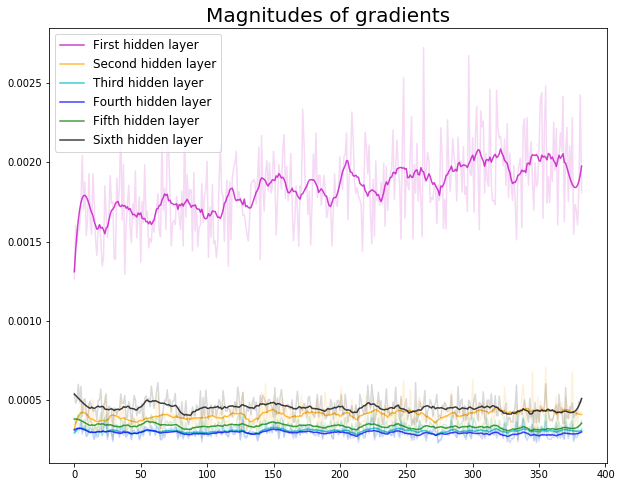

In [14]:
u3.plt_gradients(gradients)

# Exercise 4

- Plot the $\tanh$ activation function and its derivative: <br>
1) Write a function which returns the tanh for arbitrary input values. <br>
2) Write a function which returns the derivative of the tanh for arbitrary input values. <br>
3) Plot them together.

In [15]:
def tanh(x):
    return np.tanh(x)


def dtanh(x):
    return 1.0 - np.tanh(x)**2

def plt_activation_tanh():
    X = np.linspace(-5, 5, 100)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    Y_tanh = tanh(X)
    Y_dtanh = dtanh(X)
    
    plt.plot(X, Y_tanh, c='#307EC7', linewidth=3, label='tanh')
    plt.plot(X, Y_dtanh, c='#ADD8E6', linewidth=3, label='derivative of tanh')
    plt.title('Tanh activation function')
    plt.legend(prop={'size': 15})

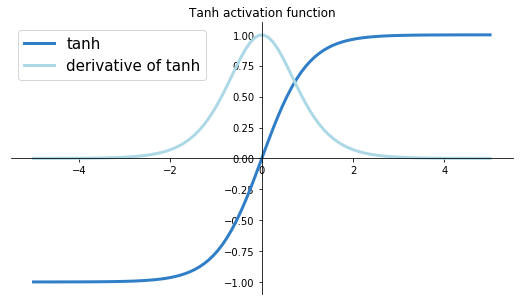

In [16]:
plt_activation_tanh()

# Exercise 5

- Plot the $\text{selu}$ activation function and its derivative: <br>
1) Write a function which returns $\text{selu}(x)$ for arbitrary input values $x$. <br>
2) Write a function which returns the derivative of $\text{selu}(x)$ for arbitrary input values $x$. <br>
3) Plot them together. <br>

- The $\text{selu}$ function is defined as following:
\begin{align*}
selu(x)=\lambda\begin{cases}
    x & \text{if } x\geq 0\\
    \alpha\exp(x)-\alpha              & \text{if } x<0
\end{cases} 
\end{align*}
where $\alpha = 1.6732...$ and $\lambda = 1.0507...$ 

In [17]:
lambda_ = 1.0507
alpha_ = 1.6732

def selu(x):
    result = []
    for element in x:
        if element >= 0:
            result.append(lambda_ * element)
        elif element < 0:
            result.append(lambda_ * (alpha_ * np.exp(element) - alpha_))
    return np.array(result)

def dselu(x):
    result = []
    for element in x:
        if element >= 0:
            result.append(lambda_)
        elif element < 0:
            result.append(lambda_ * alpha_ * np.exp(element))
    return np.array(result)

def plt_activation_selu():
    X = np.linspace(-2.5, 2.5, 500)

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.ylim(-2., 2.)
    
    Y_selu = selu(X)
    Y_dselu = dselu(X)
    
    plt.plot(X, Y_selu, c='#307EC7', linewidth=3, label='selu')
    plt.plot(X, Y_dselu, c='#ADD8E6', linewidth=3, label='derivative of selu')
    plt.title('selu activation function')
    plt.legend(prop={'size': 15})

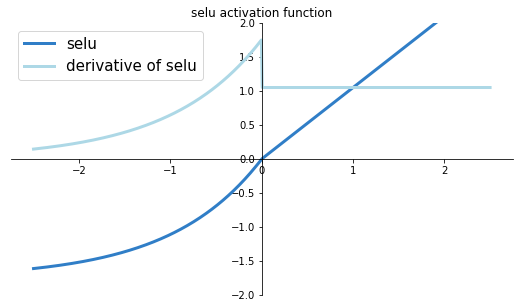

In [18]:
plt_activation_selu()

# Exercise 6

- Repeat the steps of Exercise 3, but use a $\text{selu}$ activation function instead of the $\tanh$ activation function.<br> (Hint: use the nn.SELU() function)

In [19]:
class neural_network_selu(nn.Module):
    def __init__(self, D_in, D_out):
        super(neural_network_selu, self).__init__()
        
        self.model = nn.Sequential(
             nn.Linear(D_in, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, 512, bias=True),
             nn.SELU(),
             nn.Linear(512, D_out)
         )   

    def forward(self, x):
        return self.model(x)

In [20]:
neural_network_model_selu = neural_network_selu(input_dim, output_dim)

In [21]:
neural_network_model_selu

neural_network_selu(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SELU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SELU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): SELU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): SELU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): SELU()
    (10): Linear(in_features=512, out_features=512, bias=True)
    (11): SELU()
    (12): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [22]:
np.random.seed(42)
torch.manual_seed(42)

n_epochs = 5

optimizer = optim.SGD(neural_network_model_selu.parameters(), lr=1e-3, momentum=0.5)

for epoch in range(n_epochs):
    gradients = u3.train_network(model=neural_network_model_selu, data_loader=fashion_mnist_loader_train,
                                optimizer=optimizer, device=target_device)
    loss_train, accuracy_train = u3.test_network(model=neural_network_model_selu, 
                                                 data_loader=fashion_mnist_loader_train, device=target_device)
    print(f'Epoch ({str(epoch + 1).zfill(len(str(n_epochs)))}) / Loss: {loss_train:.4f} /' +
          f' Accuracy: {accuracy_train:.4f}')

loss_test, accuracy_test = u3.test_network(model=neural_network_model_selu, data_loader=fashion_mnist_loader_train,
                                          device=target_device)
print(f'\nFinal Score / Loss: {loss_test:.4f} / Accuracy: {accuracy_test:.4f}')

Epoch (1) / Loss: 0.0039 / Accuracy: 0.8238
Epoch (2) / Loss: 0.0032 / Accuracy: 0.8562
Epoch (3) / Loss: 0.0029 / Accuracy: 0.8671
Epoch (4) / Loss: 0.0028 / Accuracy: 0.8723
Epoch (5) / Loss: 0.0028 / Accuracy: 0.8682

Final Score / Loss: 0.0028 / Accuracy: 0.8682


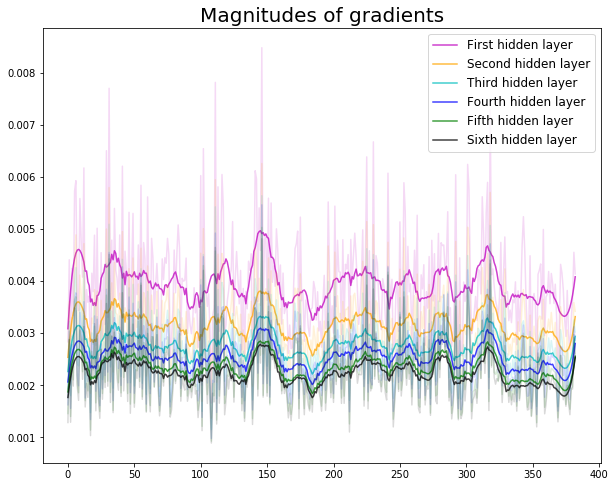

In [23]:
u3.plt_gradients(gradients)